# <center>Diabetes Disease Detection</center>

## Overview:
Diabetes is a disease that occurs when your blood glucose, also called blood sugar, is too high. Glucose is your body’s main source of energy. Your body can make glucose, but glucose also comes from the food you eat. Insulin is a hormone made by the pancreas that helps glucose get into your cells to be used for energy. If you have diabetes, your body doesn’t make enough—or any—insulin, or doesn’t use insulin properly. Glucose then stays in your blood and doesn’t reach your cells. Diabetes raises the risk for damage to the eyes, kidneys, nerves, and heart. Diabetes is also linked to some types of cancer.

## Dataset Information:
PIMA Indian Dataset: [Kaggle - Diabetes Disease Detection](https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database)

### Independent Feature:
* Outcome

### Dependent Feature:
* Pregnancies	
* Glucose	
* BloodPressure	
* SkinThickness	
* Insulin	
* BMI	
* DiabetesPedigreeFunction	
* Age

### Training : Testing :: 800 : 200 :: 80 : 20

### Evaluation Metrics Considered:
* Accuracy, Precision, Recision, F1 Score, ROC AUC Curve

# 1. Importing required libraries
* NumPy: For numerical computations and array manipulation.
* Pandas: For data manipulation and analysis.
* Seaborn: For statistical data visualization.
* Matplotlib: For creating plots and visualizations.
* Scikit-learn: For machine learning algorithms and evaluation metrics.
* XGBoost: For Extreme gradient boosting machine learning. 

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score


from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier

# 2. Data Ingestion

In [2]:
df = pd.read_csv('Data/diabetes.csv')
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


# 3. Data Exploration

In [3]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [4]:
df.shape

(768, 9)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [6]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [7]:
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [8]:
df["Outcome"].value_counts()

Outcome
0    500
1    268
Name: count, dtype: int64

# 4. Data Preprocessing

### 4.1 Data Sampling

In [9]:
df["Outcome"].value_counts()

class_0 = df[df["Outcome"]==0]
class_1 = df[df["Outcome"]==1]

In [10]:
class_0.shape

(500, 9)

In [11]:
class_1.shape

(268, 9)

In [12]:
df_n = class_1.sample(500, replace=True)
df = pd.concat([class_0, df_n], axis=0)
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
1,1,85,66,29,0,26.6,0.351,31,0
3,1,89,66,23,94,28.1,0.167,21,0
5,5,116,74,0,0,25.6,0.201,30,0
7,10,115,0,0,0,35.3,0.134,29,0
10,4,110,92,0,0,37.6,0.191,30,0
...,...,...,...,...,...,...,...,...,...
280,0,146,70,0,0,37.9,0.334,28,1
642,6,147,80,0,0,29.5,0.178,50,1
417,4,144,82,32,0,38.5,0.554,37,1
2,8,183,64,0,0,23.3,0.672,32,1


In [13]:
df.shape

(1000, 9)

### 4.2 Feature Classification

In [14]:
categorical_columns = []
numerical_columns = []

for col in df.columns:
    if df[col].dtype == 'object':
        categorical_columns.append(col)
    else:
        numerical_columns.append(col)

In [15]:
print("Numerical Features: ",numerical_columns)

print("\nCategorical Features: ",categorical_columns)

Numerical Features:  ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']

Categorical Features:  []


In [16]:
discrete_features=[feature for feature in numerical_columns if len(df[feature].unique())<25]
discrete_features

['Pregnancies', 'Outcome']

In [17]:
continuous_features=[feature for feature in numerical_columns if feature not in discrete_features]
continuous_features

['Glucose',
 'BloodPressure',
 'SkinThickness',
 'Insulin',
 'BMI',
 'DiabetesPedigreeFunction',
 'Age']

### 4.3 Training and Testing Data Preparation

In [20]:
x =  df.drop(columns=['Outcome'],axis=1)
y = df['Outcome']

In [21]:
x

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
1,1,85,66,29,0,26.6,0.351,31
3,1,89,66,23,94,28.1,0.167,21
5,5,116,74,0,0,25.6,0.201,30
7,10,115,0,0,0,35.3,0.134,29
10,4,110,92,0,0,37.6,0.191,30
...,...,...,...,...,...,...,...,...
280,0,146,70,0,0,37.9,0.334,28
642,6,147,80,0,0,29.5,0.178,50
417,4,144,82,32,0,38.5,0.554,37
2,8,183,64,0,0,23.3,0.672,32


### 4.4 Feature Scaling

In [22]:
scaler = StandardScaler()
x = scaler.fit_transform(x)

In [23]:
x_train, x_test, y_train, y_test =train_test_split(x,y,test_size=0.20,random_state=40,stratify=df['Outcome'])

# 5. Modelling

### 5.1 Model Training

In [24]:
models = {
    'Logistic Regression': LogisticRegression(),
    'Naive Bayes': GaussianNB(),
    'Random Forest Classifier': RandomForestClassifier(n_estimators=20, max_depth=10),
    'XG Boost': XGBClassifier(learning_rate=0.01, n_estimators=25, max_depth=15, gamma=0.6, subsample=0.52, colsample_bytree=0.6, seed=27,
                              reg_lambda=2, booster='dart', colsample_bylevel=0.6, colsample_bynode=0.5),
    'K Nearest Neighbors': KNeighborsClassifier(n_neighbors=10),
    'Decision Tree': DecisionTreeClassifier(criterion='entropy', random_state=0, max_depth=6),
    'Support Vector Machine': SVC(kernel='rbf', C=2, probability=True),
    'AdaBoost Classifier': AdaBoostClassifier(),
    'Gradient Boosting Classifier': GradientBoostingClassifier(),
    'Extra Trees Classifier': ExtraTreesClassifier()
}

In [25]:
model_list = []
train_accuracy_list = []
test_accuracy_list = []
precision_list = []
recall_list = []
f1_list = []

for model_name, model in models.items():

    model.fit(x_train, y_train)
    y_pred_train = model.predict(x_train)
    y_pred = model.predict(x_test)
    
    train_accuracy = accuracy_score(y_train,y_pred_train)
    test_accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print(f"Model: {model_name}")
    print(f"Training Accuracy: ",train_accuracy)
    print("Testing Accuracy: ", test_accuracy)
    print("Precision: ",precision)
    print("Recall: ",recall)
    print("F1 Score: ",f1)


    model_list.append(model_name)
    train_accuracy_list.append(train_accuracy)
    test_accuracy_list.append(test_accuracy)
    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)

    print("=" * 35)

max_accuracy_index = test_accuracy_list.index(max(test_accuracy_list))
print(f"\nThe best model based on accuracy is {model_list[max_accuracy_index]} with Testing Accuracy: {test_accuracy_list[max_accuracy_index]}")

Model: Logistic Regression
Training Accuracy:  0.7875
Testing Accuracy:  0.73
Precision:  0.73
Recall:  0.73
F1 Score:  0.73
Model: Naive Bayes
Training Accuracy:  0.75875
Testing Accuracy:  0.735
Precision:  0.7582417582417582
Recall:  0.69
F1 Score:  0.7225130890052356
Model: Random Forest Classifier
Training Accuracy:  0.99
Testing Accuracy:  0.825
Precision:  0.7927927927927928
Recall:  0.88
F1 Score:  0.8341232227488151
Model: XG Boost
Training Accuracy:  0.84625
Testing Accuracy:  0.745
Precision:  0.7094017094017094
Recall:  0.83
F1 Score:  0.7649769585253456
Model: K Nearest Neighbors
Training Accuracy:  0.80375
Testing Accuracy:  0.72
Precision:  0.7156862745098039
Recall:  0.73
F1 Score:  0.7227722772277227
Model: Decision Tree
Training Accuracy:  0.875
Testing Accuracy:  0.78
Precision:  0.7978723404255319
Recall:  0.75
F1 Score:  0.7731958762886598
Model: Support Vector Machine
Training Accuracy:  0.85125
Testing Accuracy:  0.765
Precision:  0.7476635514018691
Recall:  0.8


In [26]:
results = {
    'Model': model_list,
    'Train Accuracy': train_accuracy_list,
    'Test Accuracy': test_accuracy_list,
    'Precision': precision_list,
    'Recall': recall_list,
    'F1 Score': f1_list
}

results = pd.DataFrame(results)
results

,Model,Train Accuracy,Test Accuracy,Precision,Recall,F1 Score
0,Logistic Regression,0.78750,0.730,0.730000,0.73,0.730000
1,Naive Bayes,0.75875,0.735,0.758242,0.69,0.722513
2,Random Forest Classifier,0.99000,0.825,0.792793,0.88,0.834123
3,XG Boost,0.84625,0.745,0.709402,0.83,0.764977
4,K Nearest Neighbors,0.80375,0.720,0.715686,0.73,0.722772
5,Decision Tree,0.87500,0.780,0.797872,0.75,0.773196
6,Support Vector Machine,0.85125,0.765,0.747664,0.80,0.772947
7,AdaBoost Classifier,0.84750,0.785,0.771429,0.81,0.790244
8,Gradient Boosting Classifier,0.93750,0.795,0.765766,0.85,0.805687
9,Extra Trees Classifier,1.00000,0.820,0.796296,0.86,0.826923


### 5.2 Hyperparamter Tuning

In [27]:
param_grid = {
    'Logistic Regression': {'C': [0.1, 1, 10]},
    'Random Forest Classifier': {'n_estimators': [50, 100], 'max_depth': [5, 10]},
    'XG Boost': {'learning_rate': [0.01, 0.1], 'n_estimators': [50, 100], 'max_depth': [10, 15]},
    'K Nearest Neighbors': {'n_neighbors': [5, 10, 15]},
    'Decision Tree': {'max_depth': [5, 10]},
    'Support Vector Machine': {'C': [1, 10]},
    'AdaBoost Classifier': {'n_estimators': [50, 100]},
    'Gradient Boosting Classifier': {'n_estimators': [50, 100]},
    'Extra Trees Classifier': {'n_estimators': [50, 100]}
}

In [28]:
modelss =[]
train_accuracies = []
test_accuracies = []
precisions = []
recalls = []
f1_scores = []

for model_name, model in models.items():
    if model_name in param_grid:
        grid_search = GridSearchCV(model, param_grid[model_name], cv=5, n_jobs=-1)
        
        grid_search.fit(x_train, y_train)
        best_model_cv = grid_search.best_estimator_
        best_params = grid_search.best_params_
        print(f"\nBest parameters for {model_name}: {best_params}")
        
        y_train_pred = best_model_cv.predict(x_train)
        y_pred = best_model_cv.predict(x_test)
        
        train_accuracy = accuracy_score(y_train, y_train_pred)
        test_accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        
        modelss.append(model_name)
        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)
        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1)
        
        print(f"Train Accuracy for {model_name}: {train_accuracy}")
        print(f"Test Accuracy for {model_name}: {test_accuracy}")
        print(f"Precision for {model_name}: {precision}")
        print(f"Recall for {model_name}: {recall}")
        print(f"F1 Score for {model_name}: {f1}")
        print("=" * 35)

best_test_accuracy_index = test_accuracies.index(max(test_accuracies))
print(f"We got {modelss[best_test_accuracy_index]} as highest test acuracy of {test_accuracies[best_test_accuracy_index]}")


Best parameters for Logistic Regression: {'C': 1}
Train Accuracy for Logistic Regression: 0.7875
Test Accuracy for Logistic Regression: 0.73
Precision for Logistic Regression: 0.73
Recall for Logistic Regression: 0.73
F1 Score for Logistic Regression: 0.73

Best parameters for Random Forest Classifier: {'max_depth': 10, 'n_estimators': 50}
Train Accuracy for Random Forest Classifier: 0.995
Test Accuracy for Random Forest Classifier: 0.845
Precision for Random Forest Classifier: 0.8
Recall for Random Forest Classifier: 0.92
F1 Score for Random Forest Classifier: 0.8558139534883721

Best parameters for XG Boost: {'learning_rate': 0.1, 'max_depth': 15, 'n_estimators': 100}
Train Accuracy for XG Boost: 0.92125
Test Accuracy for XG Boost: 0.775
Precision for XG Boost: 0.7477477477477478
Recall for XG Boost: 0.83
F1 Score for XG Boost: 0.7867298578199052

Best parameters for K Nearest Neighbors: {'n_neighbors': 5}
Train Accuracy for K Nearest Neighbors: 0.86625
Test Accuracy for K Nearest N

In [29]:
results1 = {
    'Model': modelss,
    'Train Accuracy': train_accuracies,
    'Test Accuracy': test_accuracies,
    'Precision': precisions,
    'Recall': recalls,
    'F1 Score': f1_scores
}

results1 = pd.DataFrame(results1)
results1

,Model,Train Accuracy,Test Accuracy,Precision,Recall,F1 Score
0,Logistic Regression,0.78750,0.730,0.730000,0.73,0.730000
1,Random Forest Classifier,0.99500,0.845,0.800000,0.92,0.855814
2,XG Boost,0.92125,0.775,0.747748,0.83,0.786730
3,K Nearest Neighbors,0.86625,0.730,0.694915,0.82,0.752294
4,Decision Tree,0.97625,0.820,0.790909,0.87,0.828571
5,Support Vector Machine,0.90625,0.795,0.780952,0.82,0.800000
6,AdaBoost Classifier,0.85125,0.755,0.757576,0.75,0.753769
7,Gradient Boosting Classifier,0.93750,0.795,0.765766,0.85,0.805687
8,Extra Trees Classifier,1.00000,0.840,0.840000,0.84,0.840000


## ROC AUC Curve Representation

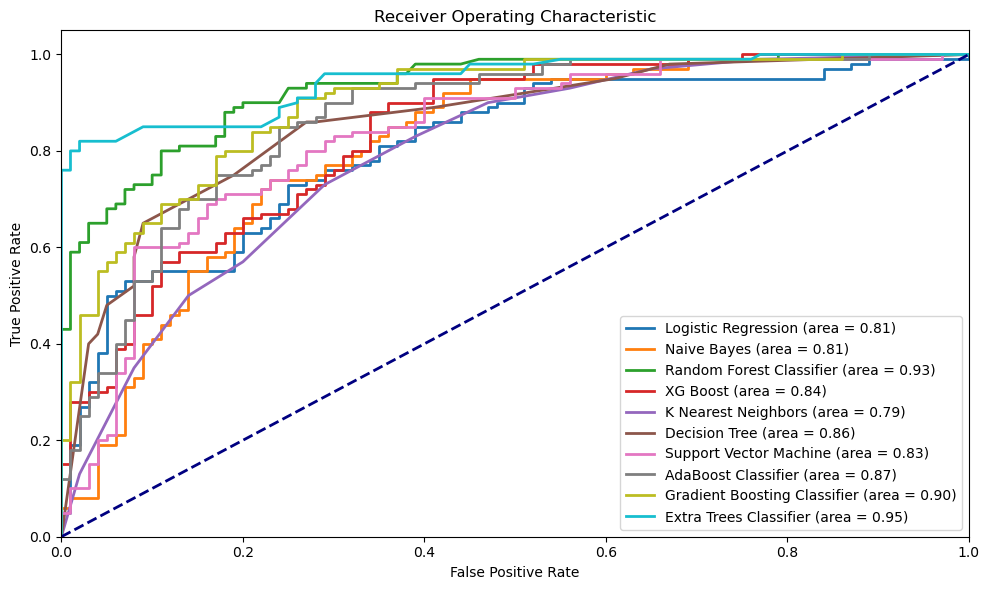

In [30]:
def plot_roc_curve(ax, y_true, y_score, model_name):
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    roc_auc = roc_auc_score(y_true, y_score)
    ax.plot(fpr, tpr, lw=2, label='%s (area = %0.2f)' % (model_name, roc_auc))


fig, ax = plt.subplots(figsize=(10, 6))

for model_name, model in models.items():
    model.fit(x_train, y_train)
    y_score = model.predict_proba(x_test)[:, 1]
    plot_roc_curve(ax, y_test, y_score, model_name)


ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver Operating Characteristic')
ax.legend(loc="lower right")
plt.tight_layout()
plt.show()

In [31]:
best_model = models['Extra Trees Classifier']
pickle.dump(best_model,open('Diabetes_Model.pkl','wb'))
pickle.dump(scaler,open('Diabetes_Preprocessor.pkl','wb'))

# 6. Model File Testing

In [32]:
import pickle

model = pickle.load(open("../Artifacts/Diabetes_Disease/Diabetes_Model.pkl", "rb"))
processor = pickle.load(open("../Artifacts/Diabetes_Disease/Diabetes_Preprocessor.pkl", "rb"))

data = processor.transform([x_train[0]])
predictions = model.predict(data)

print(predictions)

[0]
